In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define filepaths
path_coe = 'data/COEBiddingResultsPrices.csv'
path_deregistered = 'data/MotorVehiclesDeRegisteredUnderVehicleQuotaSystemMonthly.csv'
path_registered = 'data/NewRegistrationOfMotorVehiclesUnderVehicleQuotaSystemMonthly.csv'
path_cpi = 'data/outputFile.xlsx'
path_nom_household = 'data/NominalChangeinAverageMonthlyHouseholdEmploymentIncomePerHouseholdMemberExcludingEmployerCPFContributionsAmongResidentEmployedHouseholdsbyDecilesHouseholdEmploymentIncomeAnnual20002024.csv'
#path_real_household = 'data/RealChangeinMonthlyHouseholdEmploymentIncomePerHouseholdMemberExcludingEmployerCPFContributionsAmongResidentEmployedHouseholdsatSelectedPercentilesHouseholdEmploymentIncomeAnnual20002024.csv'
#path_core_inflation = 'data/MAS Core Inflation.xlsx'

# Load datasets
coe = pd.read_csv(path_coe, thousands=',') #thousands separator causing issues
deregistered = pd.read_csv(path_deregistered)
registered = pd.read_csv(path_registered)
cpi = pd.read_excel(path_cpi, sheet_name='T7', skiprows=10) #the only xlsx file
nom_household = pd.read_csv(path_nom_household)
#real_household = pd.read_csv(path_real_household)
#inflation = pd.read_excel(path_core_inflation)

def transpose_df(df):
    df_t = df.transpose()
    df_t.columns = df_t.iloc[0] #declare header
    df_t = df_t[1:] #remove extra header
    df_t.reset_index(inplace=True)
    df_t.rename_axis(None, axis=1, inplace=True) #index was called "Data Series"
    return df_t

# Function to convert date format to YYYY-MM in digits
def convert_date_format(x, original_months, converted_months, index_monthstart, index_yearend):
    ref_dict = dict(zip(original_months, converted_months))
    this_date = x[index_monthstart:] #start the search from the 5th character to skip the year and space
    return f'{x[:index_yearend]}-{ref_dict[this_date]}'

# (OLD) Function to rebase values to their corresponding month in a base year
def rebase_index_old(df, year_base, year_start, year_end_excl, label_time, label_value, list_months): #only for unique year-months
    list_years = [i for i in range(year_start,year_end_excl)]
    for month in list_months:
        base_year_month_value = float(df.loc[df[label_time] == f'{year_base}-{month}',label_value].iloc[0])
        for year in list_years:
            try:
                current_value = float(df.loc[df[label_time] == f'{year}-{month}',label_value].iloc[0])
                rebased_value = round((current_value / base_year_month_value) * 100,3)
                df.loc[df[label_time] == f'{year}-{month}', f'{label_value}_rebased'] = rebased_value
            except: #dates may not be found
                print(f'Error for {year} {month}: {df.loc[df[str(label_time)] == f'{year}-{month}']}')
                pass
    return df

# (NEW) Returns the rebased value for a single row, using specifc date format YYYY-MM
def rebase_index(row, staticdf, year_base, label_time, label_value, label_category=True): #optional label_category just for coe
    value = row[label_value]
    month = row[label_time][5:]
    #print(f'{month}: {value}')
    if label_category==True: #no category label, no need secondary check
        #print('no secondary condition')
        value_base = float(staticdf.loc[staticdf[label_time] == f'{year_base}-{month}', label_value].iloc[0])
        #print(value_base)
        return round(value/value_base*100,3)
    else:
        value_base = float(staticdf.loc[(staticdf[label_time] == f'{year_base}-{month}') & (staticdf[label_category] == row[label_category]), label_value].iloc[0])
        #print(f'base value: {value_base}')
        return round(value/value_base*100,3)
    
def get_common_dates(df_list, date_col_name):
    df1 = df_list[0]
    common_dates = [date for date in df1[date_col_name].to_list()]
    for each_other_df in df_list[1:]:
        for date in common_dates:
            if date not in each_other_df[date_col_name].to_list():
                common_dates.remove(date)
    return common_dates

def basicprep_cpi(cpi, index_monthstart, index_yearend):
    cpi_t = transpose_df(cpi)
    cpi_t.rename(columns={'index': 'month'}, inplace=True)
    cpi_mainmetrics = cpi_t.loc[:, ['month','All Items']] #only interested in 'All Items'
    cpi_mainmetrics_sorted = cpi_mainmetrics[::-1] #reverse the order to have earliest month first

    # Cut off at earliest date of coe dataset
    index_of_earliestdate = cpi_mainmetrics_sorted[cpi_mainmetrics_sorted['month'] == '2010 Jan'].index[0]
    cpi_mainmetrics_sorted_earliestdate = cpi_mainmetrics_sorted.loc[index_of_earliestdate:]

    # Convert date format to YYYY-MM
    text_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    numerical_months = ['01','02','03','04','05','06','07','08','09','10','11','12']
    cpi_mainmetrics_sorted_earliestdate.loc[:,'month'] = cpi_mainmetrics_sorted_earliestdate.loc[:,'month'].apply(convert_date_format, args=(text_months, numerical_months, index_monthstart, index_yearend))
    
    # Re-base to 2010 months
    #cpi_mainmetrics_sorted_earliestdate_rebased = rebase_index_old(cpi_mainmetrics_sorted_earliestdate, 2010, 2010, 2026, 'month', 'All Items', numerical_months)
    cpi_mainmetrics_sorted_earliestdate['cpi_reindexed'] = cpi_mainmetrics_sorted_earliestdate.apply(rebase_index, axis=1, args=(cpi_mainmetrics_sorted_earliestdate.copy(), 2010, 'month', 'All Items'))
    
    # Convert month column to datetime
    cpi_mainmetrics_sorted_earliestdate['month'] = pd.to_datetime(cpi_mainmetrics_sorted_earliestdate['month'], format='%Y-%m')

    return cpi_mainmetrics_sorted_earliestdate

def basicprep_coe(coe):
    # Cut off at last date of Nov 2025
    index_of_2025Nov = coe[coe['month'] == '2025-11'].index[-1] #get the last occurrence
    coe_nov25 = coe.loc[:index_of_2025Nov]

    # Average bids 1 and 2
    coe_nov25_bidavg = coe_nov25.groupby(['month','vehicle_class']).mean().reset_index().drop(columns=['bidding_no'])

    # Flatten multiindex columns
    coe_nov25_bidavg.columns = coe_nov25_bidavg.columns.to_flat_index()
    #coe_nov25_bidavg.to_csv('temp.csv')

    # Index COE premiums to 2010 values
    coe_nov25_bidavg['coe_indexed'] = coe_nov25_bidavg.apply(rebase_index, axis=1, args=(coe_nov25_bidavg.copy(), 2010, 'month', 'premium', 'vehicle_class'))

    # Convert month column to datetime
    coe_nov25_bidavg['month'] = pd.to_datetime(coe_nov25_bidavg['month'], format='%Y-%m')
    return coe_nov25_bidavg

def basicprep_vehregs(df, index_monthstart, index_yearend):
    df_t = transpose_df(df)
    df_t.rename(columns={'index': 'month', '    Category A: Cars':'Category A', '    Category B: Cars':'Category B', '    Category D: Motorcycles & Scooters':'Category D'}, inplace=True)
    #print(df_t.columns) #discovered the leading spaces
    df_mainmetrics = df_t.loc[:, ['month','Category A', 'Category B', 'Category D']]

    # Convert date format to YYYY-MM
    text_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    numerical_months = ['01','02','03','04','05','06','07','08','09','10','11','12']
    df_mainmetrics.loc[:,'month'] = df_mainmetrics.loc[:,'month'].apply(convert_date_format, args=(text_months, numerical_months, index_monthstart, index_yearend))
    
    # Convert month column to datetime and other columns to int
    #df_mainmetrics = df_mainmetrics.astype({'month': 'datetime64[ns]', 'Category A': int, 'Category B': int, 'Category D': int}) #error caused by a '-' value
    df_mainmetrics = df_mainmetrics.replace('-', 0) # for the specific error case
    df_mainmetrics['month'] = pd.to_datetime(df_mainmetrics['month'], format='%Y-%m')
    df_mainmetrics['Category A'] = df_mainmetrics['Category A'].fillna(0).astype(int)
    df_mainmetrics['Category B'] = df_mainmetrics['Category B'].fillna(0).astype(int)
    df_mainmetrics['Category D'] = df_mainmetrics['Category D'].fillna(0).astype(int)
    return df_mainmetrics
    

In [119]:
# CPI dataset
df_cpi = basicprep_cpi(cpi, 5, 4)

# COE dataset
df_coe = basicprep_coe(coe)
df_coe_a = df_coe.loc[df_coe['vehicle_class'] == 'Category A']
df_coe_b = df_coe.loc[df_coe['vehicle_class'] == 'Category B']
df_coe_d = df_coe.loc[df_coe['vehicle_class'] == 'Category D']

# Trim datasets to only the common dates so that we can plot
df_list = [df_cpi, df_coe_a, df_coe_b, df_coe_d]
common_dates = get_common_dates(df_list, 'month')
df_cpi_trim = df_cpi[df_cpi['month'].isin(common_dates)]
df_coe_a_trim = df_coe_a[df_coe_a['month'].isin(common_dates)]
df_coe_b_trim = df_coe_b[df_coe_b['month'].isin(common_dates)]
df_coe_d_trim = df_coe_d[df_coe_d['month'].isin(common_dates)]

C:\Users\user\AppData\Local\Temp\ipykernel_1624\3282875010.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_mainmetrics_sorted_earliestdate['cpi_reindexed'] = cpi_mainmetrics_sorted_earliestdate.apply(rebase_index, axis=1, args=(cpi_mainmetrics_sorted_earliestdate.copy(), 2010, 'month', 'All Items'))
C:\Users\user\AppData\Local\Temp\ipykernel_1624\3282875010.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_mainmetrics_sorted_earliestdate['month'] = pd.to_datetime(cpi_mainmetrics_sorted_earli

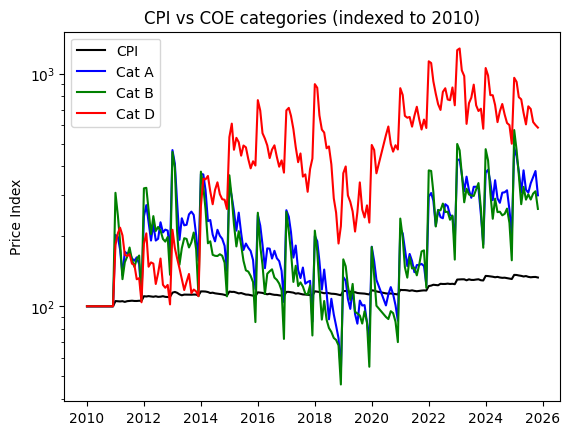

In [ ]:
x = df_cpi_trim['month']
plt.plot(x, df_cpi_trim['cpi_reindexed'], label='CPI', color='black')
plt.plot(x, df_coe_a_trim['coe_indexed'], label='Cat A', color='blue')
plt.plot(x, df_coe_b_trim['coe_indexed'], label='Cat B', color='green')
plt.plot(x, df_coe_d_trim['coe_indexed'], label='Cat D', color='red')

plt.title('CPI vs COE categories (indexed to 2010)')
#plt.xlabel('Months')
plt.ylabel('Price Index')
plt.yscale('log') # Set the y-axis to a logarithmic scale
plt.legend()
plt.tick_params(axis='x', labelrotation=0)

plt.show()


In [127]:
# Process vehicle registration and deregistration datasets
registered_prep = basicprep_vehregs(registered, 4, 4)
deregistered_prep = basicprep_vehregs(deregistered, 4, 4)

# Trim datasets to only the common dates so that we can plot
df_list = [df_coe_a_trim, registered_prep, deregistered_prep] #use df_coe_a_trim as reference
common_dates = get_common_dates(df_list, 'month')
df_registered_trim = registered_prep[registered_prep['month'].isin(common_dates)]
df_deregistered_trim = deregistered_prep[deregistered_prep['month'].isin(common_dates)]

# Combined both datasets to get net registrations
net_registrations = pd.merge(df_registered_trim,df_deregistered_trim, how='inner', on='month', suffixes=('_registered', '_deregistered'))

for category in ['Category A', 'Category B', 'Category D']:
    net_registrations[f'Net {category}'] = net_registrations[f'{category}_registered'] - net_registrations[f'{category}_deregistered']
    net_registrations.drop(columns=[f'{category}_registered', f'{category}_deregistered'], inplace=True)

net_registrations

,month,Net Category A,Net Category B,Net Category D
0,2025-11-01,114,61,483
1,2025-10-01,-562,-181,297
2,2025-09-01,259,171,594
3,2025-08-01,-134,-151,329
4,2025-07-01,451,91,256
...,...,...,...,...
183,2010-05-01,354,917,-19
184,2010-04-01,591,970,38
185,2010-03-01,754,869,126
186,2010-02-01,536,1204,173


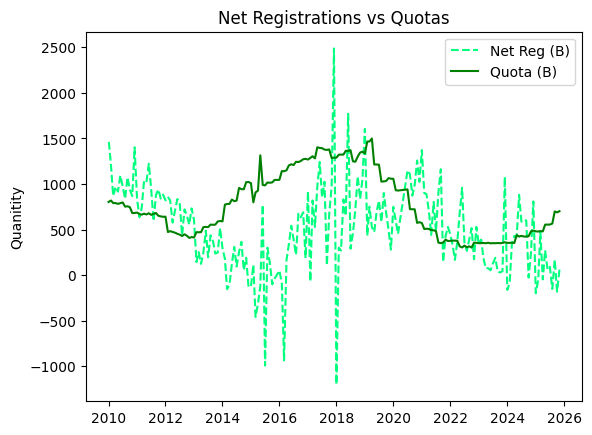

In [133]:
x = net_registrations['month']
#plt.plot(x, net_registrations['Net Category A'], label='Net Reg (A)', color='cornflowerblue',  linestyle='--')
plt.plot(x, net_registrations['Net Category B'], label='Net Reg (B)', color='springgreen',  linestyle='--')
#plt.plot(x, net_registrations['Net Category D'], label='Net Reg (D)', color='lightcoral',  linestyle='--')
#plt.plot(x, df_coe_a_trim['quota'], label='Quota (A)', color='blue', linestyle='-')
plt.plot(x, df_coe_b_trim['quota'], label='Quota (B)', color='green', linestyle='-')
#plt.plot(x, df_coe_d_trim['quota'], label='Quota (D)', color='red', linestyle='-')

plt.title('Net Registrations vs Quotas')
#plt.xlabel('Months')
plt.ylabel('Quanitity')
plt.yscale('linear') # Set the y-axis to a linear scale
plt.legend()
plt.tick_params(axis='x', labelrotation=0)

plt.show()


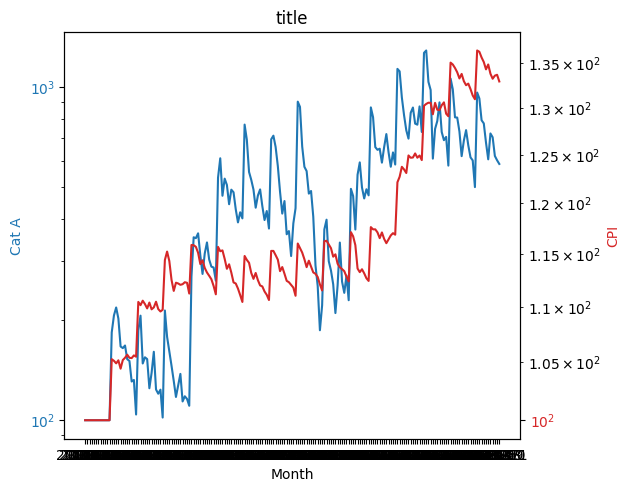

In [114]:
def plot_twin_axis(x, y1, y2, y1_label, y2_label, title):
    fig, ax1 = plt.subplots()

    colour_ax1 = 'tab:blue'
    ax1.set_xlabel('Month')
    ax1.set_ylabel(y1_label, color=colour_ax1)
    ax1.plot(x, y1, color=colour_ax1)
    ax1.tick_params(axis='y', labelcolor=colour_ax1)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    colour_ax2 = 'tab:red'
    ax2.set_ylabel(y2_label, color=colour_ax2)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=colour_ax2)
    ax2.tick_params(axis='y', labelcolor=colour_ax2)

    plt.xticks(rotation=90)
    ax1.autoscale(enable=True, axis='x')
    ax2.autoscale(enable=True, axis='x')
    ax1.set_yscale('log')
    ax2.set_yscale('log')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()

plot_twin_axis(df_cpi_trim['month'], df_coe_d_trim['coe_indexed'], df_cpi_trim['cpi_reindexed'], 'Cat A', 'CPI', 'title')